## Методы на нейронных сетях

Подключаемые модули

In [0]:
import pandas as pd
import numpy as np
import pickle
import math

Подгрузка данных о доменных именах с диска 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/input data/training_data.pkl', 'rb') as f:
  training_data = pickle.load(f)

Общая коллекция данных

In [0]:
all_data_dict = pd.concat([training_data['legit'], training_data['dga']], ignore_index=True)

Массивы обучения

In [0]:
# Массив x хранит образцы обучения
# В массиве y хранятся целевые значения (метки типов) для образцов обучения
X = np.array(all_data_dict['domain'].tolist())
y = np.array(all_data_dict['type'].tolist())

In [6]:
X

array(['netflix', 'api-global', 'prod', ..., 'iumgkaoasgoyiccy',
       'aemosuaokkwmqqmq', 'eimgukowkqeckykg'], dtype='<U63')

In [7]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
from tensorflow.keras.preprocessing import sequence

In [0]:
# Создание словаря действительных символов
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}

In [10]:
valid_chars

{'-': 15,
 '0': 20,
 '1': 6,
 '2': 26,
 '3': 36,
 '4': 29,
 '5': 5,
 '6': 12,
 '7': 10,
 '8': 31,
 '9': 25,
 'a': 37,
 'b': 18,
 'c': 19,
 'd': 21,
 'e': 3,
 'f': 11,
 'g': 16,
 'h': 28,
 'i': 4,
 'j': 34,
 'k': 2,
 'l': 13,
 'm': 24,
 'n': 33,
 'o': 17,
 'p': 30,
 'q': 22,
 'r': 23,
 's': 14,
 't': 9,
 'u': 32,
 'v': 8,
 'w': 27,
 'x': 35,
 'y': 7,
 'z': 1}

In [0]:
# 38 уникальных символов
max_features = len(valid_chars) + 1 

In [0]:
# 63 макс последовательность символов
maxlen = np.max([len(x) for x in X]) 

In [0]:
# Преобразование символов в int и pad (последовательности одиннаковой длины)
X = [[valid_chars[y] for y in x] for x in X]
X = sequence.pad_sequences(X, maxlen=maxlen)

In [14]:
X

array([[ 0,  0,  0, ..., 13,  4, 35],
       [ 0,  0,  0, ..., 18, 37, 13],
       [ 0,  0,  0, ..., 23, 17, 21],
       ...,
       [ 0,  0,  0, ..., 19, 19,  7],
       [ 0,  0,  0, ..., 22, 24, 22],
       [ 0,  0,  0, ...,  7,  2, 16]], dtype=int32)

Построение модели

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SimpleRNN, GRU, Convolution1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# 33% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [0]:
# Метод Endgame (LSTM)
modelEnd = Sequential()
modelEnd.add(Embedding(max_features, 128, input_length=maxlen))
modelEnd.add(LSTM(128))
modelEnd.add(Dropout(0.5))
modelEnd.add(Dense(1))
modelEnd.add(Activation('sigmoid'))
modelEnd.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Метод 2 (SimpleRNN)
modelSR = Sequential()
modelSR.add(Embedding(max_features, 128, input_length=maxlen))
modelSR.add(SimpleRNN(128))
modelSR.add(Dropout(0.5))
modelSR.add(Dense(1))
modelSR.add(Activation('sigmoid'))
modelSR.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Метод 3 (GRU)
modelGRU = Sequential()
modelGRU.add(Embedding(max_features, 128, input_length=maxlen))
modelGRU.add(GRU(128))
modelGRU.add(Dropout(0.5))
modelGRU.add(Dense(1))
modelGRU.add(Activation('sigmoid'))
modelGRU.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Метод 4 (CNN)
modelCNN = Sequential()
modelCNN.add(Embedding(max_features, 128, input_length=maxlen))
modelCNN.add(Convolution1D(filters=32, kernel_size=4))
modelCNN.add(GlobalMaxPooling1D())
modelCNN.add(Dense(128))
modelCNN.add(Dropout(0.5))
modelCNN.add(Activation('relu'))
modelCNN.add(Dense(1))
modelCNN.add(Activation('sigmoid'))
modelCNN.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Игнорирование предостережения о нехватке памяти
import warnings
warnings.filterwarnings('ignore')

Обучение + кросс-валидация

In [22]:
modelEnd.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=1024, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1207116 samples, validate on 594551 samples
Epoch 1/10
1207116/1207116 [==============================] - 293s 242us/step - loss: 0.1861 - acc: 0.9270 - val_loss: 0.1424 - val_acc: 0.9451
Epoch 2/10
1207116/1207116 [==============================] - 290s 240us/step - loss: 0.1031 - acc: 0.9636 - val_loss: 0.0831 - val_acc: 0.9714
Epoch 3/10
1207116/1207116 [==============================] - 286s 237us/step - loss: 0.0828 - acc: 0.9718 - val_loss: 0.0736 - val_acc: 0.9746
Epoch 4/10
1207116/1207116 [==============================] - 282s 234us/step - loss: 0.0752 - acc: 0.9743 - val_loss: 0.0715 - val_acc: 0.9756
Epoch 5/10
1207116/1207116 [==============================] - 282s 234us/step - loss: 0.0701 - acc: 0.9761 - val_loss: 0.0639 - val_acc: 0.9779
Epoch 6/10
1207116/1207116 [==============================] - 282s 234us/step - loss: 0.0660 - acc: 0.9775 - val_loss: 0.0623 - val_acc: 0.9784
Epoch 7/10
1207116/1207116 [==============================] - 283s 235us/step - los

In [23]:
modelSR.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=1024, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1207116 samples, validate on 594551 samples
Epoch 1/10
1207116/1207116 [==============================] - 96s 79us/step - loss: 0.1614 - acc: 0.9391 - val_loss: 0.1102 - val_acc: 0.9610
Epoch 2/10
1207116/1207116 [==============================] - 98s 81us/step - loss: 0.1063 - acc: 0.9635 - val_loss: 0.0881 - val_acc: 0.9696
Epoch 3/10
1207116/1207116 [==============================] - 97s 80us/step - loss: 0.0945 - acc: 0.9679 - val_loss: 0.0861 - val_acc: 0.9698
Epoch 4/10
1207116/1207116 [==============================] - 98s 81us/step - loss: 0.0881 - acc: 0.9702 - val_loss: 0.0798 - val_acc: 0.9725
Epoch 5/10
1207116/1207116 [==============================] - 99s 82us/step - loss: 0.0838 - acc: 0.9716 - val_loss: 0.0762 - val_acc: 0.9740
Epoch 6/10
1207116/1207116 [==============================] - 99s 82us/step - loss: 0.0805 - acc: 0.9728 - val_loss: 0.0745 - val_acc: 0.9745
Epoch 7/10
1207116/1207116 [==============================] - 99s 82us/step - loss: 0.0781 - ac

In [24]:
modelGRU.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=1024, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1207116 samples, validate on 594551 samples
Epoch 1/10
1207116/1207116 [==============================] - 232s 192us/step - loss: 0.1838 - acc: 0.9284 - val_loss: 0.1186 - val_acc: 0.9588
Epoch 2/10
1207116/1207116 [==============================] - 229s 190us/step - loss: 0.1042 - acc: 0.9641 - val_loss: 0.0877 - val_acc: 0.9695
Epoch 3/10
1207116/1207116 [==============================] - 230s 190us/step - loss: 0.0823 - acc: 0.9720 - val_loss: 0.0774 - val_acc: 0.9729
Epoch 4/10
1207116/1207116 [==============================] - 233s 193us/step - loss: 0.0735 - acc: 0.9752 - val_loss: 0.0742 - val_acc: 0.9742
Epoch 5/10
1207116/1207116 [==============================] - 237s 197us/step - loss: 0.0683 - acc: 0.9771 - val_loss: 0.0640 - val_acc: 0.9781
Epoch 6/10
1207116/1207116 [==============================] - 238s 197us/step - loss: 0.0641 - acc: 0.9784 - val_loss: 0.0628 - val_acc: 0.9786
Epoch 7/10
1207116/1207116 [==============================] - 237s 196us/step - los

In [34]:
modelCNN.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=1024, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1207116 samples, validate on 594551 samples
Epoch 1/10
1207116/1207116 [==============================] - 22s 18us/step - loss: 0.1719 - acc: 0.9362 - val_loss: 0.1310 - val_acc: 0.9549
Epoch 2/10
1207116/1207116 [==============================] - 21s 17us/step - loss: 0.1245 - acc: 0.9568 - val_loss: 0.1117 - val_acc: 0.9616
Epoch 3/10
1207116/1207116 [==============================] - 21s 17us/step - loss: 0.1147 - acc: 0.9606 - val_loss: 0.1097 - val_acc: 0.9611
Epoch 4/10
1207116/1207116 [==============================] - 21s 17us/step - loss: 0.1090 - acc: 0.9627 - val_loss: 0.1025 - val_acc: 0.9640
Epoch 5/10
1207116/1207116 [==============================] - 21s 17us/step - loss: 0.1048 - acc: 0.9643 - val_loss: 0.1008 - val_acc: 0.9649
Epoch 6/10
1207116/1207116 [==============================] - 21s 17us/step - loss: 0.1020 - acc: 0.9655 - val_loss: 0.0967 - val_acc: 0.9669
Epoch 7/10
1207116/1207116 [==============================] - 21s 17us/step - loss: 0.0999 - ac

Тестирование на отложенной выборке

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from itertools import product

In [0]:
y_scoreEnd = modelEnd.predict_proba(X_test)
y_predEnd = y_scoreEnd.round()

In [0]:
y_scoreSR = modelSR.predict_proba(X_test)
y_predSR = y_scoreSR.round()

In [0]:
y_scoreGRU = modelGRU.predict_proba(X_test)
y_predGRU = y_scoreGRU.round()

In [0]:
y_scoreCNN = modelCNN.predict_proba(X_test)
y_predCNN = y_scoreCNN.round()

In [0]:
y_pred = [y_predEnd, y_predSR, y_predGRU, y_predCNN]
y_score = [y_scoreEnd, y_scoreSR, y_scoreGRU, y_scoreCNN]
labels = ['legit', 'dga']
names = ["Endgame (LSTM)", "SimpleRNN", "GRU", "CNN"]

In [44]:
for y_pr, y_sc, name in zip(y_pred, y_score, names):
    print(name)
    print("Accuracy score : ", accuracy_score(y_test, y_pr))
    print("Precision score : ", precision_score(y_test, y_pr))
    print("Recall score : ", recall_score(y_test, y_pr))
    print("F1 score : ", f1_score(y_test, y_pr))
    print("ROC AUC score : ", roc_auc_score(y_test, y_sc))
    print("Average Precision score : ", average_precision_score(y_test, y_sc))
    print("\n")


Endgame (LSTM)
Accuracy score :  0.9813523146037935
Precision score :  0.975661232598401
Recall score :  0.9825799521950924
F1 score :  0.9791083700307712
ROC AUC score :  0.9976917077455616
Average Precision score :  0.9968025110237764


SimpleRNN
Accuracy score :  0.9758742311424924
Precision score :  0.9703138635611327
Recall score :  0.975598317751354
F1 score :  0.9729489152409402
ROC AUC score :  0.9962873962327456
Average Precision score :  0.9946028883211787


GRU
Accuracy score :  0.9809166917556273
Precision score :  0.9711706746702613
Recall score :  0.986369550089256
F1 score :  0.978711108275761
ROC AUC score :  0.99751316876609
Average Precision score :  0.9965171075199565


CNN
Accuracy score :  0.9660550566730188
Precision score :  0.9622515804216981
Recall score :  0.9613854346313273
F1 score :  0.9618183125290874
ROC AUC score :  0.9927036178616817
Average Precision score :  0.98868271237895




Матрица ошибок (Confusion Matrix)

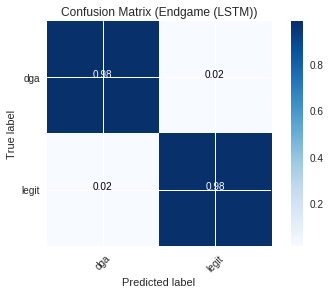

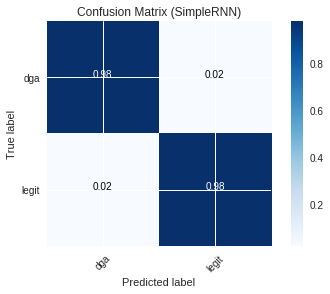

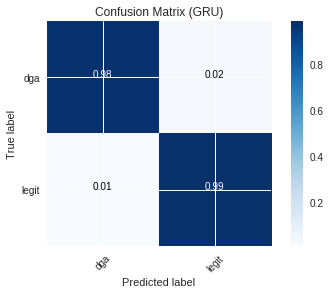

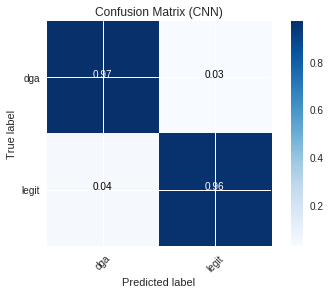

In [40]:
for y_pr, name in zip(y_pred, names):  
    cm = confusion_matrix(y_test, y_pr)
    np.set_printoptions(precision=2)

    cm = cm.astype('float') / cm.sum(axis=1).T[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (" + name + ")")
    plt.colorbar()
    plt.xticks([1, 0], labels, rotation=45)
    plt.yticks([1, 0], labels)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

ROC-кривая

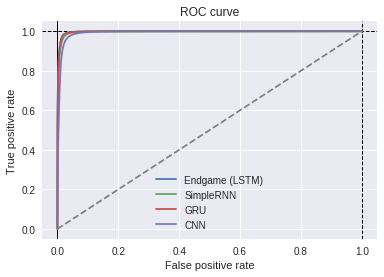

In [43]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
for y_sc, name in zip(y_score, names):
    fpr, tpr, thresholds = roc_curve(y_test, y_sc)
    plt.plot(fpr, tpr, label=name)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 

Кривая Точность-Полнота (Precision-Recall)

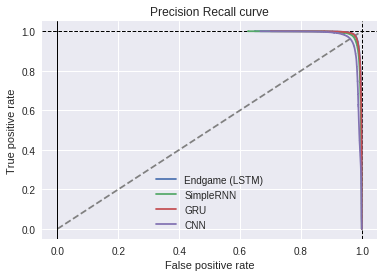

In [42]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
for y_sc, name in zip(y_score, names):
    fpr, tpr, thresholds = precision_recall_curve(y_test, y_sc)
    plt.plot(fpr, tpr, label=name)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Precision Recall curve')
plt.legend(loc='best')
plt.show()